## Business Understanding

**Methodology**: CRISP-DM

**Project Objectives and Requirements**: Build a classifier to predict whether an arrest was made after a Terry Stop, given information about the presence of weapons, the time of day of the call, etc. Note that this is a binary classification problem.

## Data Understanding

### Import Relevant Libraries and Import Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import the data
df = pd.read_csv('Terry_Stops.csv')

df_copy = df # Create a copy of df

# Print the first five rows
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,-,-,-,NaN,N,N,-,-,-


### Non Obvious Column Descriptions

* **Officer Squad**: Functional sqaud assignment (not budget) of the officer as reported by the Data Analytics Platform (DAP)
* **Call Type**: How the call was recieved by the communication center
* **GO / SC Num**: "General Offense" or Street Check Number, relating the Terry Stop to the Parent Report
* **Terry Stop ID**: Key Identifying Terry Stop Reports
* **Stop Resolution**: Resolution of the Stop as reported by the officer
* **Arrest Flag**: Indicator of whether or not a physical arrest was Made, of the subject, during the Terry Stop. Does not necessarily relfect a report of an arrest in Records Management System (RMS)
* **Frisk Flag**: Indicator of whether a frisk was conducted
* **Sector**: Sector of the address associated with the Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred
* **Beat**: Beat of the address associated with the underlying Computer Aided (CAD) event. Not nen=cessarily where the Terry Stop occurred

### Identify Data Quality Problems

In [3]:
# Check for Null Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43077 entries, 0 to 43076
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         43077 non-null  object
 1   Subject ID                43077 non-null  int64 
 2   GO / SC Num               43077 non-null  int64 
 3   Terry Stop ID             43077 non-null  int64 
 4   Stop Resolution           43077 non-null  object
 5   Weapon Type               43077 non-null  object
 6   Officer ID                43077 non-null  object
 7   Officer YOB               43077 non-null  int64 
 8   Officer Gender            43077 non-null  object
 9   Officer Race              43077 non-null  object
 10  Subject Perceived Race    43077 non-null  object
 11  Subject Perceived Gender  43077 non-null  object
 12  Reported Date             43077 non-null  object
 13  Reported Time             43077 non-null  object
 14  Initial Call Type     

In [4]:
# Print the Summary Stats of all Columns of Type "Int"
df.describe()

,Subject ID,GO / SC Num,Terry Stop ID,Officer YOB
count,4.307700e+04,4.307700e+04,4.307700e+04,43077.000000
mean,1.725100e+09,2.017332e+13,2.235567e+09,1982.581958
std,3.592390e+09,1.577498e+10,4.560857e+09,8.910558
min,-1.000000e+00,2.009000e+13,2.802000e+04,1900.000000
25%,-1.000000e+00,2.016000e+13,1.666560e+05,1978.000000
50%,-1.000000e+00,2.017000e+13,3.637270e+05,1985.000000
75%,-1.000000e+00,2.019000e+13,5.339190e+05,1989.000000
max,1.381718e+10,2.020000e+13,1.381743e+10,1997.000000


In [5]:
df.isna().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Weapon Type                   0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               543
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
dtype: int64

In [6]:
# Check for Duplicate Rows
duplicates = df[df.duplicated()]
print(len(duplicates))
duplicates.head()

0


,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat


In [7]:
# Check Each Column for Extraneous Values
for col in df.columns:
    print(col, '\n', df[col].value_counts().head(), '\n\n')

Subject Age Group 
 26 - 35         14282
36 - 45          9049
18 - 25          8809
46 - 55          5531
56 and Above     2145
Name: Subject Age Group, dtype: int64 


Subject ID 
 -1             34668
 7726859935       18
 7753260438       11
 7727117712       11
 7727827572        8
Name: Subject ID, dtype: int64 


GO / SC Num 
 20160000378750    16
20150000190790    16
20180000134604    14
20170000132836    13
20190000441736    13
Name: GO / SC Num, dtype: int64 


Terry Stop ID 
 13080077761    3
9585545373     2
12601385662    2
12608907801    2
12781960580    2
Name: Terry Stop ID, dtype: int64 


Stop Resolution 
 Field Contact               17029
Offense Report              14774
Arrest                      10381
Referred for Prosecution      728
Citation / Infraction         165
Name: Stop Resolution, dtype: int64 


Weapon Type 
 None                                 32565
-                                     8060
Lethal Cutting Instrument             1482
Knife/Cutting/S

In [8]:
# Detect Placeholder Data
for col in df.columns:
    print(col, '\n', df[col].unique(), '\n\n')

Subject Age Group 
 ['-' '1 - 17' '18 - 25' '26 - 35' '36 - 45' '46 - 55' '56 and Above'] 


Subject ID 
 [         -1  7726713382  7727213211 ... 13340719601 13511274122
 13734413940] 


GO / SC Num 
 [20140000120677 20150000001463 20150000001516 ... 20200000182302
 20200000198579 20200000197261] 


Terry Stop ID 
 [      92317       28806       29599 ... 13340733030 13754619046
 13734441031] 


Stop Resolution 
 ['Arrest' 'Field Contact' 'Citation / Infraction' 'Offense Report'
 'Referred for Prosecution'] 


Weapon Type 
 ['None' 'Firearm Other' 'Lethal Cutting Instrument' 'Handgun' '-'
 'Club, Blackjack, Brass Knuckles' 'Knife/Cutting/Stabbing Instrument'
 'Rifle' 'Fire/Incendiary Device' 'Firearm (unk type)' 'Other Firearm'
 'Mace/Pepper Spray' 'None/Not Applicable' 'Club'
 'Blunt Object/Striking Implement' 'Firearm' 'Shotgun' 'Brass Knuckles'
 'Automatic Handgun' 'Taser/Stun Gun' 'Blackjack'] 


Officer ID 
 ['7500  ' '5670  ' '4844  ' ... '5786  ' '5917  ' '8804  '] 


Officer Y

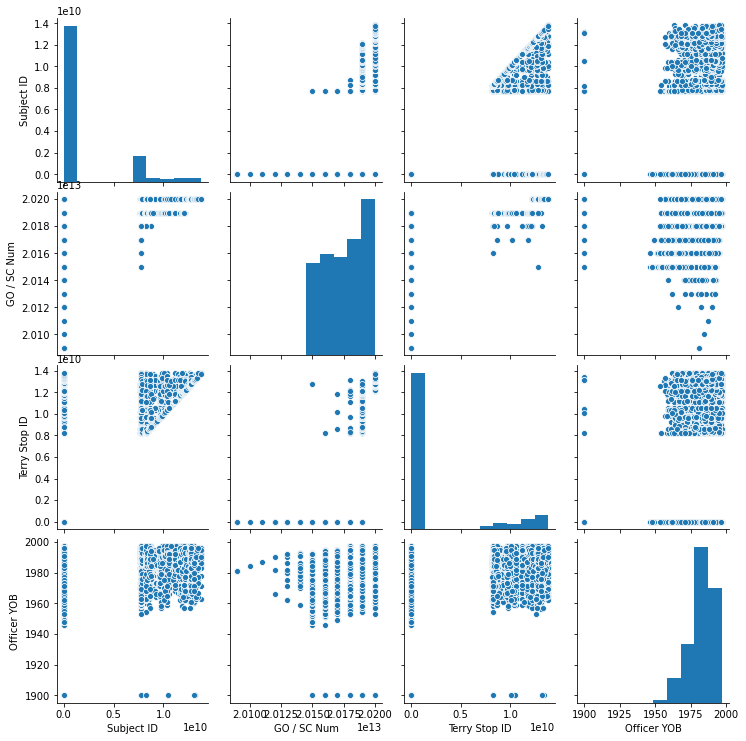

In [9]:
sns.pairplot(df)

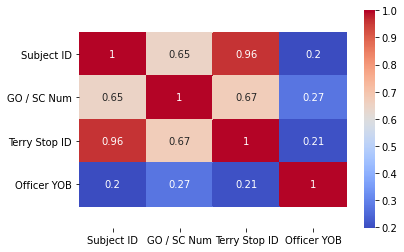

In [10]:
# Display the Correlation on a Heat Map 
sns.heatmap(df.corr(), annot=True, cmap = 'coolwarm')  #Heatmap with Correlations overlaid on features.

# Scale the Heat Map, so the correlation values are centered and ledgeable
b, t = plt.ylim() # Discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() 

### Develop First Insights



#### Multicollinearity
* Subject ID vs Terry Stop ID exhbit high Multicollinearity
* Subject ID vs GO / SC Num Multicollinearity
* Terry Stop ID vs GO / SC Num Multicollinearity
* Will drop Subject ID in the next section



## Data Preparation

### Cleaning

#### Replace Place Holder Values with the Mode Values for that Specific Column

In [11]:
# Find the Mode Values of each column to Replace Extraneous Values
df.mode()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,26 - 35,-1.0,20150000190790,1.308008e+10,Field Contact,None,7456,1986.0,M,White,...,19:18:00,-,-,911,TRAINING - FIELD TRAINING SQUAD,N,N,West,-,-
1,NaN,NaN,20160000378750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Replace Placeholder Data
df['Subject Age Group'] = df['Subject Age Group'].replace('-', '26 - 35')

# List Under Assumptions
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace('Unable to Determine', 
    'Gender Diverse (gender non-conforming and/or transgender)').replace('Unknown', 'Gender Diverse (gender non-conforming and/or transgender)').replace('-', 'Male')

df['Subject Perceived Race'] = df['Subject Perceived Race'].replace('-', 'Other')
df['Officer Gender'] = df['Officer Gender'].replace('N', 'M')
df['Frisk Flag'] = df['Frisk Flag'].replace('-', 'N')                                  

In [13]:
officer_squad_mode = df['Officer Squad'].mode().values[0] # Find the mode of the Officer Squad column
df['Officer Squad'].fillna(officer_squad_mode, inplace=True) # Replace NaN values in the Officer Squad column with the mode value

In [14]:
# Sanity Check
df.isna().sum()

Subject Age Group           0
Subject ID                  0
GO / SC Num                 0
Terry Stop ID               0
Stop Resolution             0
Weapon Type                 0
Officer ID                  0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Reported Time               0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Officer Squad               0
Arrest Flag                 0
Frisk Flag                  0
Precinct                    0
Sector                      0
Beat                        0
dtype: int64

#### Replace Place Holder Values, and Convert Important Columns with over 40% Placeholder Values to Categorical - 0's & 1's

In [15]:
# Switch Weapon Type to Weapon (0's & 1's)
Weapon = [] # Initialize a an Empty List
for value in df['Weapon Type']:
    if value == 'None': # Replace "None" Values with "0" 
        Weapon.append(0)
    else:
        Weapon.append(1) # Replace Other Values with "0" 
df['Weapon'] = Weapon # Create a New Column Called "Weapon"
df.head() # Print First 5 Rows of DataFrame 




,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon
0,26 - 35,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2,0
1,26 - 35,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,-,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0
2,26 - 35,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,-,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0
3,26 - 35,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,-,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0
4,26 - 35,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,-,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0


In [16]:
# Switch Call Type to Call Made/No Call Made (0's & 1's)
call_made = [] # Initialize a an Empty List
for value in df['Call Type']:
    if value == '-':  
        call_made.append(0) # Replace "-" Values with "0"
    else:
        call_made.append(1) # Replace Other Values with "1"
df['Call Made'] = call_made # Create a New Column Called "Call Made"
df.head() # Print First 5 Rows of DataFrame



,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon,Call Made
0,26 - 35,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2,0,0
1,26 - 35,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0
2,26 - 35,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0
3,26 - 35,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0
4,26 - 35,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0


In [17]:
arrest_made = [] # Initialize a an Empty List

for value in df['Arrest Flag']:
    if value == 'N':  
        arrest_made.append(0) # Replace "N" Values with "0"
    else:
        arrest_made.append(1) # Replace "Y" Values with "1"
df['Arrest Made'] = arrest_made # Create a New Column Called "Arrest Made"

df.head() # Print First 5 Rows of DataFrame

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon,Call Made,Arrest Made
0,26 - 35,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2,0,0,0
1,26 - 35,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0,0
2,26 - 35,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0,0
3,26 - 35,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0,0
4,26 - 35,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0,0


In [18]:
frisk = [] # Create an empty list

for value in df['Frisk Flag']:
    if value == 'N':  
        frisk.append(0) # Replace "N" Values with "0"
    else:
        frisk.append(1) # Replace "Y" Values with "1"
df['Frisk'] = frisk # Create a New Column Called

df.head() # Print First 5 Rows of DataFrame

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon,Call Made,Arrest Made,Frisk
0,26 - 35,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2,0,0,0,0
1,26 - 35,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0,0,0
2,26 - 35,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0,0,0
3,26 - 35,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0,0,0
4,26 - 35,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,0,0,0,0


In [19]:
df['Reported Date'] = pd.to_datetime(df['Reported Date'])  # Convert 'Reported Date' to a Datetime Data Type From Object 
df['Year Reported'] = pd.DatetimeIndex(df['Reported Date']).year # Extract the year and assign them to a new dataframe column "Year Reported"
df['Year Reported'] = df['Year Reported'].astype(int) # Convert from datetime object to int.
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon,Call Made,Arrest Made,Frisk,Year Reported
0,26 - 35,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,N,N,South,O,O2,0,0,0,0,2015
1,26 - 35,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,N,N,-,-,-,0,0,0,0,2015
2,26 - 35,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,N,N,-,-,-,0,0,0,0,2015
3,26 - 35,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,N,N,-,-,-,0,0,0,0,2015
4,26 - 35,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,N,N,-,-,-,0,0,0,0,2015


In [20]:
officers_over100 = df.loc[(df['Officer YOB'] == 1900) & (df['Year Reported'] >= 1980)] # Find all officers who were born in the year 1900 and "made arrests" after 1980
indices_todrop = officers_over100.index # Find the indices where officers over 100 years old are stored 
df.drop(indices_todrop, axis=0, inplace=True) # Drop the rows by index

In [21]:
# Create a DataFrame to use for EDA 
df_eda = df.drop(['Precinct', 'Sector', 'Subject ID', 'Weapon Type', 'Reported Date', 'Terry Stop ID', 'Arrest Flag', 'Frisk Flag', 'GO / SC Num'], axis=1)
df_eda.head()



,Subject Age Group,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Beat,Weapon,Call Made,Arrest Made,Frisk,Year Reported
0,26 - 35,Arrest,7500,1984,M,Black or African American,Asian,Male,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,O2,0,0,0,0,2015
1,26 - 35,Field Contact,5670,1965,M,White,Other,Male,07:59:00,-,-,-,TRAINING - FIELD TRAINING SQUAD,-,0,0,0,0,2015
2,26 - 35,Field Contact,4844,1961,M,White,White,Male,19:12:00,-,-,-,TRAINING - FIELD TRAINING SQUAD,-,0,0,0,0,2015
3,26 - 35,Field Contact,7539,1963,M,White,Other,Male,04:55:00,-,-,-,TRAINING - FIELD TRAINING SQUAD,-,0,0,0,0,2015
4,26 - 35,Field Contact,6973,1977,M,White,Black or African American,Male,00:41:00,-,-,-,TRAINING - FIELD TRAINING SQUAD,-,0,0,0,0,2015


In [22]:
df_eda.to_csv('Terry_Cleaned_forEDA.csv')

In [23]:
df = df.drop(['Sector', 'Reported Time', 'Initial Call Type', 'Final Call Type', 'Precinct', 'Subject ID', 'Weapon Type', 'Call Type', 'Beat', 'Reported Date', 'Terry Stop ID', 'Officer ID', 'Arrest Flag', 'Frisk Flag', 'GO / SC Num'], axis=1)
df.head()


,Subject Age Group,Stop Resolution,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Officer Squad,Weapon,Call Made,Arrest Made,Frisk,Year Reported
0,26 - 35,Arrest,1984,M,Black or African American,Asian,Male,SOUTH PCT 1ST W - ROBERT,0,0,0,0,2015
1,26 - 35,Field Contact,1965,M,White,Other,Male,TRAINING - FIELD TRAINING SQUAD,0,0,0,0,2015
2,26 - 35,Field Contact,1961,M,White,White,Male,TRAINING - FIELD TRAINING SQUAD,0,0,0,0,2015
3,26 - 35,Field Contact,1963,M,White,Other,Male,TRAINING - FIELD TRAINING SQUAD,0,0,0,0,2015
4,26 - 35,Field Contact,1977,M,White,Black or African American,Male,TRAINING - FIELD TRAINING SQUAD,0,0,0,0,2015


In [24]:
df.info() # Final Check for NaNs

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43063 entries, 0 to 43076
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         43063 non-null  object
 1   Stop Resolution           43063 non-null  object
 2   Officer YOB               43063 non-null  int64 
 3   Officer Gender            43063 non-null  object
 4   Officer Race              43063 non-null  object
 5   Subject Perceived Race    43063 non-null  object
 6   Subject Perceived Gender  43063 non-null  object
 7   Officer Squad             43063 non-null  object
 8   Weapon                    43063 non-null  int64 
 9   Call Made                 43063 non-null  int64 
 10  Arrest Made               43063 non-null  int64 
 11  Frisk                     43063 non-null  int64 
 12  Year Reported             43063 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 4.6+ MB


In [25]:
# Save Cleaned DataFrame as CSV to use for Modeling
df.to_csv('Terry_Cleaned.csv')